Sweeping lattice size
x points
3
y points
3
z points
3


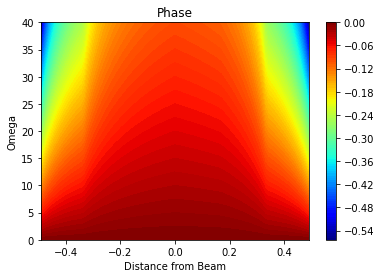

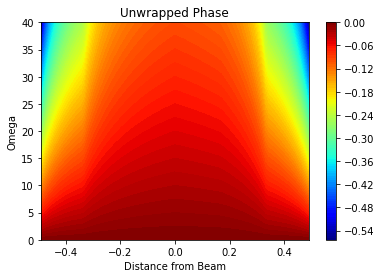

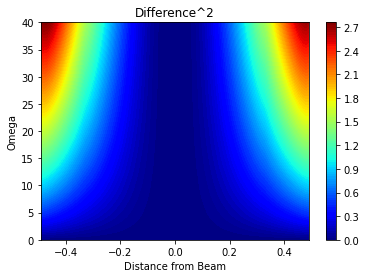

x points
5
y points
5
z points
5


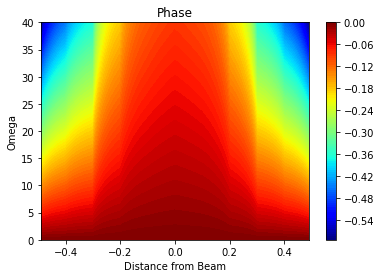

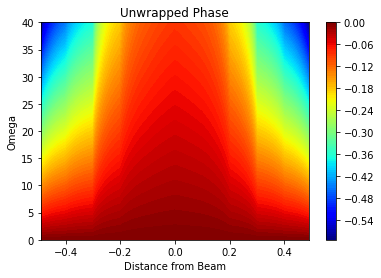

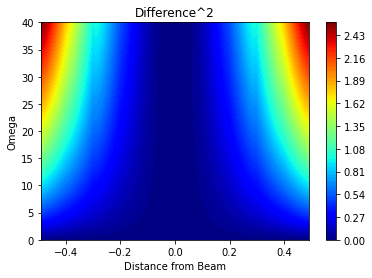

x points
7
y points
7
z points
7


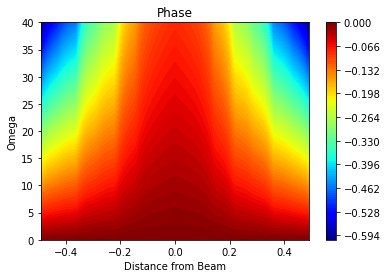

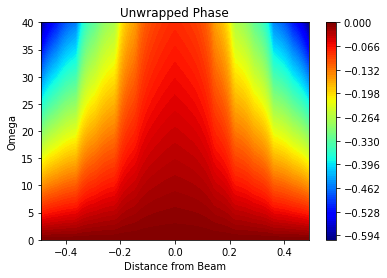

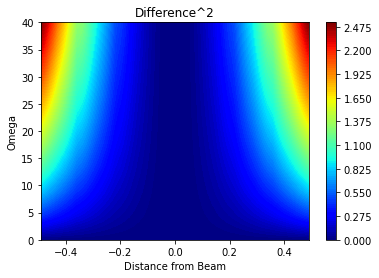

In [1]:
from dolfin import *
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

spacing = .01
depth = 1
#omega = 20
n=1
tol = 1E-14
#Dx = omega/(2*36*np.pi**2)
Dx = 1
Dy = 1
Dz = 1
theta = np.pi/2
#umax = 2*np.pi*n
#xmax = umax*np.sqrt(2/omega)
truexc = 0
trueyc = 0
xcenter = truexc/np.sqrt(Dx)
ycenter = trueyc/np.sqrt(Dy)
rdefect = .01
#xspace = .1
#yspace = .1
ndefectx = 5
ndefecty = 4
e = .1
beta = .89

#set lattice sizes to test with each iteration
xtry = np.array([3,5,7])
ytry = np.array([3,5,7])
ztry = np.array([3,5,7])

#set sample dimensions (constant)
truex = 1
truey = 1
truez = .1

#xpoints = 5
#ypoints = 5
#zpoints = 5

#truextry = np.array([0.5, 1, 2])
#trueytry = np.array([0.5, 1, 2])
#trueztry = np.array([0.5, 1, 2])

#set omegas to sweep between
omegamin = 0
omegamax = 40

xmax = truex/np.sqrt(Dx)
ymax = truey/np.sqrt(Dy)
zmax = truez/np.sqrt(Dz)
xdefect = np.linspace(-truex/2, truex/2, ndefectx)/np.sqrt(Dx)
ydefect = np.linspace(-truey/2, truey/2, ndefecty)/np.sqrt(Dy)

#q_degree = 3
#dx = dx(metadata={'quadrature_degree': q_degree})

def solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, W):
    
    #(ureal, uimag, sigma, mu) = TrialFunctions(W)
    #(v1, v2, v3, v4) = TestFunctions(W)
    (ureal, uimag) = TrialFunctions(W)
    (v1, v2) = TestFunctions(W)

    #a = (dot(grad(uimag),grad(v1)) + omega/alpha*ureal*v1 + omega/alpha*uimag*v2 - dot(grad(ureal),grad(v2)) + sigma*v3 + dot(grad(ureal), grad(v3)) + mu*v4 + dot(grad(uimag), grad(v4)))*dx 
    a = (dot(grad(uimag),grad(v1)) + omega/alpha*ureal*v1 + omega/alpha*uimag*v2 - dot(grad(ureal),grad(v2)))*dx
    L =  - g/alpha*v2*dx
    
    def bot(x, on_boundary): return on_boundary and near(x[2], -zmax/2, tol)
    noslip = Constant(0.0)
    bc0 = DirichletBC(W.sub(0), noslip, bot)
    bc1 = DirichletBC(W.sub(1), noslip, bot)
    G = Expression('0', degree = 0)
    def boundary(x, on_boundary):
            return on_boundary and not near(x[2], -zmax/2, tol)    
    #bc2 = DirichletBC(W.sub(2), G, boundary)
    #bc3 = DirichletBC(W.sub(3), G, boundary)
    bcs = [bc0, bc1]

    w = Function(W)
    solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})
    
    (ureal, uimag) = w.split()
    
    return ureal, uimag

def phasef(ureal, uimag, xline, yline, depth, z):
    
    zpoints = len(z)

    wtot = 0
    upointr = 0
    upointi = 0
    #utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
    
        uliner = ureal(xline,yline,z[i])
        ulinei = uimag(xline,yline,z[i])
    
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        upointr = upointr + uliner*wlayer
        upointi = upointi + ulinei*wlayer
        #utotr = utotr + u_sheetr * wlayer
        #utoti = utoti + u_sheeti * wlayer
    
    upointr = upointr/wtot
    upointi = upointi/wtot
    #print(' ')
    #print(upointr)
    #print(upointi)
    phase = np.arctan2(upointi, upointr)
    #print(phase)
    return phase

def linepoints(theta, truexc, trueyc, truex, truey, truez, spacing):
    d = 0.0
    listpoints = np.array([[d, truexc, trueyc]])
    lookright = True 
    while lookright:
        d = d+spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > truex/2 or ytemp > truey/2 or xtemp < -truex/2 or ytemp < -truey/2:
            lookright = False
        else:
            listpoints = np.append(listpoints,[[d, xtemp, ytemp]], axis = 0)
    lookleft = True
    d = 0
    while lookleft:
        d = d - spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > truex/2 or ytemp > truey/2 or xtemp < -truex/2 or ytemp < -truey/2:
            lookleft = False
        else:
            listpoints = np.append([[d, xtemp, ytemp]],listpoints, axis = 0)
    return listpoints

def phaseline(ureal, uimag, xline, yline, depth, z):
    phasearray = np.zeros(len(xline))
    for i in range(0, len(xline)):
        phasearray[i] = phasef(ureal, uimag, xline[i], yline[i], depth, z)
     
    return phasearray

def utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal, uimag, depth): 
    wtot = 0
    utotr = np.zeros(cutnumy*cutnumx)
    utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
    
        points = [(x_, y_, z[i]) for x_ in x for y_ in y]
        u_sheetr = np.array([ureal(point) for point in points])
        u_sheeti = np.array([uimag(point) for point in points])
    
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
    
        utotr = utotr + u_sheetr * wlayer
        utoti = utoti + u_sheeti * wlayer
    
    utotr = utotr/wtot
    utoti = utoti/wtot

    utotr = np.reshape(utotr, (cutnumx, cutnumy))
    utoti = np.reshape(utoti, (cutnumx, cutnumy))

    return utotr, utoti

def testomega(ureal, uimag, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, xline, yline):
    listpoints = linepoints(theta, truexc, trueyc, truex, truey, truez, spacing)
    phasearray = phaseline(ureal, uimag, xline, yline, depth, z)
    d = listpoints[:,0]
    return d, phasearray

def omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, alpha, W, xline, yline):
    
    for i in range(0, len(omegal)):
        omega = omegal[i]
        realsolve, imagsolve = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, W)
        #imagsolve = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha)
        dsolve, phasesolve = testomega(realsolve, imagsolve, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, xline, yline)
        omegaarray = np.ones((len(dsolve), 1))*omega
        amegaarray = np.array(omegaarray)
        dsolve = np.array(dsolve)
        dsolve = np.reshape(dsolve, (len(dsolve), 1))
        
        stemp = np.concatenate((amegaarray, dsolve), axis = 1)
        phasesolve = np.reshape(phasesolve, (len(dsolve), 1))
        stemp = np.concatenate((stemp, phasesolve), axis = 1)
        #print(stemp)
        #print(np.shape(stemp))
        stemp = np.reshape(stemp, (len(dsolve), 3))
        #print(np.shape(stemp))
        if i == 0:
            output = stemp 
        else: output = np.concatenate((output, stemp))
            
    return output, dsolve

def lattice_solve(xpoints, ypoints, zpoints, omegamin, omegamax):

    p0 = Point (-xmax/2, -ymax/2, -zmax/2)
    p1 = Point (xmax/2, ymax/2, zmax/2)
    mesh = BoxMesh(p0, p1, xpoints, ypoints, zpoints)

    CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    #CG3_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    #CG4_elem = FiniteElement("CG", mesh.ufl_cell(), 1)

    #V_c = FunctionSpace(mesh, CG1_elem)

    #V_phi = FunctionSpace(mesh, CG2_elem)
    W_elem = MixedElement([CG1_elem, CG2_elem])
    W = FunctionSpace(mesh, W_elem)

    qtot = Expression('1', degree = 2)

    for i in range(0, len(xdefect)):
        for j in range(0, len(ydefect)):
            ydefectj = ydefect[j]
            xdefecti = xdefect[i]
            qtemp = Expression('1 - beta*((x[0] - xdefecti)*(x[0] - xdefecti) + (x[1] - ydefectj)*(x[1] - ydefectj) < rdefect)', degree = 2, xdefecti = xdefecti, ydefectj = ydefectj, rdefect = rdefect, beta = beta)
            qtot = qtot * qtemp 
        
    #alpha1 = qtot   
    #alpha = qtot
    alpha = 1
    #alpha2 = 1

    ktrue = 1000
    kx = ktrue*Dx
    ky = ktrue*Dy

    #f = Expression('(-b*b - 4*kx*kx*(x[0] - xcenter)*(x[0] - xcenter) + 2*kx - 4*ky*ky*(x[1] - ycenter)*(x[1] - ycenter) + 2*ky)*exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter, omega = omega)
    g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter)

    #ureal1, uimag1 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1)

    #print('Still running...')

    #ureal2, uimag2 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha2)

    #print('Still running...')

    meshpts = mesh.coordinates()
    meshpts[:, 0] *= np.sqrt(Dx)
    meshpts[:, 1] *= np.sqrt(Dy)
    meshpts[:, 2] *= np.sqrt(Dz)

    cutnumy = xpoints+1
    cutnumx = ypoints+1
    cutnumz = zpoints+1

    xn = -truex/2
    xp = truex/2
    zn = -truez/2
    zp = truez/2
    yp = truey/2
    yn = -truey/2

    y = np.linspace(yn + tol, yp - tol, cutnumy)
    x = np.linspace(xn + tol, xp - tol, cutnumx)
    z = np.linspace(zn + tol, zp - tol, cutnumz)

    #utotr1, utoti1 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal1, uimag1, depth)
    #utotr2, utoti2 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal2, uimag2, depth)




    testline = linepoints(theta, truexc, trueyc, truex, truey, truez, spacing)
    #print(testline)

    distance = testline[:, 0]
    xline = testline[:, 1]
    yline = testline[:, 2]

    #phase = phasef(ureal, uimag, xline, yline, depth, z)

    #phasearray1 = phaseline(ureal1, uimag1, xline, yline, depth, z)
    #phasearray2 = phaseline(ureal2, uimag2, xline, yline, depth, z)


    #print(phasearray)

    xv, yv = np.meshgrid(x, y)
    omegal = np.linspace(omegamin, omegamax, 10) 
    test, dl = omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, alpha, W, xline, yline)


    #print(test)

    phasen = test[:,2]
    phasen = np.reshape(phasen, (len(omegal), len(dl)))
    dn, omegan = np.meshgrid(dl, omegal)
    fig = plt.gcf()
    plt.contourf(dn, omegan, phasen, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Phase')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()

    image_unwrapped = unwrap_phase(phasen)

    imax = max(image_unwrapped.max(axis = 1))
    #print(imax)
    n = np.abs(imax)//(np.pi*2)*np.sign(imax)
    #print(n)
    image_unwrapped = image_unwrapped - 2*np.pi*n

    fig = plt.gcf()
    plt.contourf(dn, omegan, image_unwrapped, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Unwrapped Phase')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()

    #print(7//pi)
    dvec = np.sqrt(Dx**2 * np.cos(theta)**2 + Dy**2 * np.sin(theta)**2)
    phasefit = -np.sqrt(test[:,0]/2*dvec)*np.abs(test[:,1])
    phasefit = np.reshape(phasefit, (len(omegal), len(dl)))

    dif = phasefit - image_unwrapped
    fig = plt.gcf()
    plt.contourf(dn, omegan, dif**2, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Difference^2')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()
    
def samplesize_solve(xpoints, ypoints, zpoints, truex, truey, truez, Dx, Dy, Dz, rdefect, ndefectx, ndefecty, omegamin, omegamax):
    
    xmax = truex/np.sqrt(Dx)
    ymax = truey/np.sqrt(Dy)
    zmax = truez/np.sqrt(Dz)
    xdefect = np.linspace(-truex/2, truex/2, ndefectx)/np.sqrt(Dx)
    ydefect = np.linspace(-truey/2, truey/2, ndefecty)/np.sqrt(Dy)
    
    p0 = Point (-xmax/2, -ymax/2, -zmax/2)
    p1 = Point (xmax/2, ymax/2, zmax/2)
    mesh = BoxMesh(p0, p1, xpoints, ypoints, zpoints)

    CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    #CG3_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    #CG4_elem = FiniteElement("CG", mesh.ufl_cell(), 1)

    #V_c = FunctionSpace(mesh, CG1_elem)

    #V_phi = FunctionSpace(mesh, CG2_elem)
    W_elem = MixedElement([CG1_elem, CG2_elem])
    W = FunctionSpace(mesh, W_elem)

    qtot = Expression('1', degree = 2)

    for i in range(0, len(xdefect)):
        for j in range(0, len(ydefect)):
            ydefectj = ydefect[j]
            xdefecti = xdefect[i]
            qtemp = Expression('1 - beta*((x[0] - xdefecti)*(x[0] - xdefecti) + (x[1] - ydefectj)*(x[1] - ydefectj) < rdefect)', degree = 2, xdefecti = xdefecti, ydefectj = ydefectj, rdefect = rdefect, beta = beta)
            qtot = qtot * qtemp 
        
    #alpha1 = qtot   
    #alpha = qtot
    alpha = 1
    #alpha2 = 1

    ktrue = 1000
    kx = ktrue*Dx
    ky = ktrue*Dy

    #f = Expression('(-b*b - 4*kx*kx*(x[0] - xcenter)*(x[0] - xcenter) + 2*kx - 4*ky*ky*(x[1] - ycenter)*(x[1] - ycenter) + 2*ky)*exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter, omega = omega)
    g = Expression('omega*exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter, omega = omega)

    #ureal1, uimag1 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1)

    #print('Still running...')

    #ureal2, uimag2 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha2)

    #print('Still running...')

    meshpts = mesh.coordinates()
    meshpts[:, 0] *= np.sqrt(Dx)
    meshpts[:, 1] *= np.sqrt(Dy)
    meshpts[:, 2] *= np.sqrt(Dz)

    cutnumy = xpoints+1
    cutnumx = ypoints+1
    cutnumz = zpoints+1

    xn = -truex/2
    xp = truex/2
    zn = -truez/2
    zp = truez/2
    yp = truey/2
    yn = -truey/2

    y = np.linspace(yn + tol, yp - tol, cutnumy)
    x = np.linspace(xn + tol, xp - tol, cutnumx)
    z = np.linspace(zn + tol, zp - tol, cutnumz)

    #utotr1, utoti1 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal1, uimag1, depth)
    #utotr2, utoti2 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal2, uimag2, depth)




    testline = linepoints(theta, truexc, trueyc, truex, truey, truez, spacing)
    #print(testline)

    distance = testline[:, 0]
    xline = testline[:, 1]
    yline = testline[:, 2]

    #phase = phasef(ureal, uimag, xline, yline, depth, z)

    #phasearray1 = phaseline(ureal1, uimag1, xline, yline, depth, z)
    #phasearray2 = phaseline(ureal2, uimag2, xline, yline, depth, z)


    #print(phasearray)

    xv, yv = np.meshgrid(x, y)
    omegal = np.linspace(omegamin, omegamax, 10) 
    test, dl = omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, alpha, W, xline, yline)


    #print(test)

    phasen = test[:,2]
    phasen = np.reshape(phasen, (len(omegal), len(dl)))
    dn, omegan = np.meshgrid(dl, omegal)
    fig = plt.gcf()
    plt.contourf(dn, omegan, phasen, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Phase')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()

    image_unwrapped = unwrap_phase(phasen)

    imax = max(image_unwrapped.max(axis = 1))
    #print(imax)
    n = np.abs(imax)//(np.pi*2)*np.sign(imax)
    #print(n)
    image_unwrapped = image_unwrapped - 2*np.pi*n

    fig = plt.gcf()
    plt.contourf(dn, omegan, image_unwrapped, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Unwrapped Phase')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()

    #print(7//pi)
    dvec = np.sqrt(Dx**2 * np.cos(theta)**2 + Dy**2 * np.sin(theta)**2)
    phasefit = -np.sqrt(test[:,0]/2*dvec)*np.abs(test[:,1])
    phasefit = np.reshape(phasefit, (len(omegal), len(dl)))

    dif = phasefit - image_unwrapped
    fig = plt.gcf()
    plt.contourf(dn, omegan, dif**2, 100, cmap = cmx.jet)
    #plt.plot(xline, yline, c = 'black', linewidth = 3)
    plt.colorbar()
    plt.title('Difference^2')
    plt.xlabel('Distance from Beam')
    plt.ylabel('Omega')
    #fig.set_size_inches(8, truey/truex*8)
    plt.show()
    
#to sweep lattice sizes (and omega sweep at each lattice size)   
print('Sweeping lattice size')
for i in range(0, len(xtry)):
    print('x points')
    print(xtry[i])
    print('y points')
    print(ytry[i])
    print('z points')
    print(ztry[i])
    lattice_solve(xtry[i], ytry[i], ztry[i], omegamin, omegamax)
    
#to sweep sample size (and omega sweep at each sample size)
#print('Sweeping sample size')
#for i in range(0, len(truextry)):
    #print('sample x-length')
    #print(truextry[i])
    #print('sample y-length')
    #print(trueytry[i])
    #print('sample z-length')
    #print(trueztry[i])
    #samplesize_solve(xpoints, ypoints, zpoints, truextry[i], trueytry[i], trueztry[i], Dx, Dy, Dz, rdefect, ndefectx, ndefecty, omegamin, omegamax)
